In [1]:
#import requests as req
from urllib.request import urlopen, Request
import requests
import snscrape.modules.twitter as sntwitter
import pandas as pd
import os
import sqlite3 as sql
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
from wordcloud import WordCloud , ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [2]:
import textblob
from turkishnlp import detector
obj = detector.TurkishNLP()
from textblob import TextBlob
from googletrans import Translator
translator = Translator()
from google_trans_new import google_translator  


In [3]:
obj.create_word_set()


In [6]:
lwords = obj.list_words("mak")
print(obj.auto_correct(lwords))


['mak']


In [3]:
engine = create_engine('sqlite:///Vestel_database.db', echo=True)
sqlite_connection = engine.connect()


In [4]:
eksisozluk_list = []
twitter_df = []
shiftdelete_df=[]

df = pd.read_sql_query("SELECT Date_time,Text from eksisozluk_list", sqlite_connection)
df_twit= pd.read_sql_query("SELECT Date_time,Text from Tweet_list", sqlite_connection)
df_shift= pd.read_sql_query("SELECT Date_time,Text from shiftdelete_list", sqlite_connection)

# Creating a dataframe from the tweets list above
eksisozluk_df = pd.DataFrame(df, columns=['Date_time', 'Text'])
#ADD TWITTER DATA TO DATAFRAME
twitter_df = pd.DataFrame(df_twit, columns=['Date_time','Text'])
#ADD TWITTER DATA TO DATAFRAME
shiftdelete_df = pd.DataFrame(df_shift, columns=['Date_time','Text'])

#eksisozluk_df.append(shiftdelete_df,ignore_index=True, sort=False)
comments_df=eksisozluk_df.append(twitter_df,ignore_index=True, sort=False)


2021-08-23 10:45:35,904 INFO sqlalchemy.engine.Engine SELECT Date_time,Text from eksisozluk_list
2021-08-23 10:45:35,908 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-23 10:45:35,922 INFO sqlalchemy.engine.Engine SELECT Date_time,Text from Tweet_list
2021-08-23 10:45:35,924 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-23 10:45:36,418 INFO sqlalchemy.engine.Engine SELECT Date_time,Text from shiftdelete_list
2021-08-23 10:45:36,419 INFO sqlalchemy.engine.Engine [raw sql] ()


In [5]:
yorumlar_df=comments_df.append(shiftdelete_df,ignore_index=True, sort=False)

In [6]:
yorumlar_df

,Date_time,Text
0,02.05.2019 17:55,ötv zamminin arkasinda bu babadagli piyanist ş...
1,03.05.2019 00:17 ~ 00:18,çöpünü dahi kullanmadığım ve bundan sonra da k...
2,05.05.2019 22:41,2 buzdolabi2 tv2 camasir mak1 firin 1 supurge ...
3,17.05.2019 16:00,yaklaşık 1 yıl önce sba120 soundbar aldım. ald...
4,08.06.2019 14:39,cep telefonlarının dokunmatikleri 2000'li yıll...
...,...,...
82340,3 Ocak 2018,Öyle yani Bazıları reklam falan yaptırıyorlar ...
82341,3 Ocak 2018,vestel servisi iyi ki.
82342,14 Ocak 2018,ben Vestel kullandım ve şikayetçi değilim. Ves...
82343,2 Eyl 2018,Ben memnunum kişinin beklentisine göre olmalı


In [7]:
len(yorumlar_df)

82345

In [8]:
# load train data
import io

#https://www.kaggle.com/burhanbilenn/duygu-analizi-icin-urun-yorumlari?select=magaza_yorumlari_duygu_analizi.csv
dataset_train = pd.read_csv('magaza_yorumlari_duygu_analizi.csv',sep=",",encoding ='utf-16')
                  
dataset_train=dataset_train[['Görüş', 'Durum']]

In [9]:
dataset_train.tail()

,Görüş,Durum
11433,Telefonu aldım haparlör den ses gelmiyor hicbi...,Olumsuz
11434,Yorum yapan arkadaşları gerçek den anlayamıyor...,Olumsuz
11435,yazılım olarak abuk subuk ufak hatalar dolu ve...,Olumsuz
11436,1 aydır kullanıyorum ön kamerası berbat arka k...,Olumsuz
11437,Daha önce ısınma problemi var diye yorum yapmı...,Tarafsız


In [10]:
#kaynak:https://stackoverflow.com/questions/50443494/error-in-removing-punctuation-float-object-has-no-attribute-translate
dataset_train['Görüş'] = dataset_train.fillna({'Görüş':''})
x_gorus=dataset_train['Görüş']
y_durum=dataset_train['Durum']

sentiment_ordering = ['Olumsuz', 'Tarafsız', 'Olumlu']
y_durum = y_durum.apply(lambda x: sentiment_ordering.index(x))

y_durum.head()

0    0
1    1
2    2
3    0
4    0
Name: Durum, dtype: int64

In [11]:
dataset_train.head()

,Görüş,Durum
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz
1,hizli teslimat tesekkürler,Tarafsız
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz


In [12]:
import nltk
import string
import re

import turkishnlp
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import nltk as nlp
from PIL import Image

from string import punctuation, digits
#from snowballstemmer import TurkishStemmer
#https://pypi.org/project/TurkishStemmer/
from TurkishStemmer import TurkishStemmer
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [166]:
t_stopwords=[]
stop_words=set(stopwords.words('turkish'))
t_stopwords = open('turkish_stopwords.txt', 'r',encoding ='utf-8').read().split()
remove = ['VESTEL','...','“','”','Vestel','…','vestel','.....','vestelin','ve','bu','şu','’','bir']
stop_words.update(t_stopwords)
stop_words.update(remove)



def ozel_karakter (text):
    punctation = string.punctuation
    return text.translate(str.maketrans("","",punctation))

def token(values):
    
    words = word_tokenize(values)
    filtered_words = [word for word in words if (word not in stop_words)]
    #corrected_words=obj.auto_correct(filtered_words)
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

def stemming_tokenizer(text): 
    #clean_Text=detect_and_translate(text)
    stemmer= TurkishStemmer()
    #text=[stemmer.stem(word) for word in word_tokenize(text)  if ( 'http' not in word)] 
    #text=" ".join(text)
    
    lemma=nlp.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in word_tokenize(text)] # this code finds the root of the word for a word in the sentence and change them to their root form.
    text=" ".join(text)
    return text

def process_text(d): 
    
    emojis=re.compile("["
                     u"\U0001F600-\U0001F64F"
                     u"\U0001F300-\U0001F5FF" 
                     u"\U0001F680-\U0001F6FF"
                     u"\U0001F1E0-\U0001F1FF"
                     "]+",flags=re.UNICODE)
    d = d.apply(lambda x:  x.replace('I','ı'))
    d = d.apply(lambda x: re.sub("@[^\s]+", " ",x ))
    d = d.apply(lambda x: re.sub("#[^\s]+","", x))
    #lower() yapıldığı zaman I harfi i olarak çevirildiğinden dolayı replace ile düzeltildi.
    d = d.apply(lambda x: x.replace('İ','i'))
    d = d.apply(lambda x: x.lower().strip())
    d = d.apply(lambda x: re.sub(r'[0-9]+', '', x))
    d = d.apply(lambda x: x.replace('.....',' '))

    d = d.apply(lambda x: x.replace('\u200b', '').replace('\n', ''))
    #Removal of hastags/account
    d = d.apply(lambda x: ozel_karakter (x))
    d = d.apply(lambda x: re.sub('\W+', ' ', x))
    d = d.apply(lambda x: re.sub('&amp+', '&', x))
    d = d.apply(lambda x: re.sub("\d+", "", x))
    # Remove words with 2 or fewer letters
    d= d.apply(lambda x:  re.sub(r'\b\w{1,2}\b', '', x))
    # Remove whitespace (including new line characters)
    d= d.apply(lambda x: re.sub(r'\s\s+', ' ', x))
    # Remove HTML special entities (e.g. &amp;)
    d= d.apply(lambda x: re.sub(r'\&\w*;', '', x))
    #Convert @username and hastags
    #d= d.apply(lambda x:  (re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", x)))
    d= d.apply(lambda x: re.sub(r'https?:\/\/\S*', '', x, flags=re.MULTILINE))
    # Remove tickers
    d= d.apply(lambda x:  re.sub(r'http\S+', '', x))
    d= d.apply(lambda x:  re.sub(emojis, '', x))
    d= d.apply(lambda x:  re.sub(r'\$\w*', '', x))
    return  d
#https://towardsdatascience.com/4-python-libraries-to-detect-english-and-non-english-language-c82ad3efd430


from googletrans import Translator
#simple function to detect and translate text 
def detect_and_translate(text):
    
    translator = Translator()
    translate_text = translator.translate(text)
    return translate_text     



In [107]:
dataset_train['Gorus_token']=process_text(dataset_train['Görüş'])
dataset_train['Gorus_token'] = dataset_train['Gorus_token'].apply(lambda x: stemming_tokenizer(x))
dataset_train['Gorus_token']= dataset_train['Gorus_token'].apply(lambda x: token(x))
dataset_train['Gorus_token']= dataset_train['Gorus_token'].apply(lambda x:  re.sub(r'\b\w{1,2}\b', '', x))
dataset_train['Gorus_token']= dataset_train['Gorus_token'].apply(lambda x: re.sub(r'\s\s+', ' ', x))


In [108]:
dataset_train['Gorus_token'][3]


'geldi bigün kullandık hemen bozoldu hiçtavsiye etmem'

In [109]:
dataset_train.head(10)

,Görüş,Durum,Gorus_token
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz,kalitesi ergonomisi rezalet sony aldım fiyatı...
1,hizli teslimat tesekkürler,Tarafsız,hizli teslimat tesekkürler
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu,olayı süpergece çalıştır sıkıntı yok kablo uz...
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz,geldi bigün kullandık hemen bozoldu hiçtavsiye...
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz,kulaklığın sesi kaliteli aleti öve öve bitirem...
5,Giriş seviyesindeki kullanıcılar için kabul ed...,Tarafsız,giriş seviyesindeki kullanıcılar kabul edilebi...
6,kullanisli baya,Olumlu,kullanisli baya
7,Dezavantajlar : Pahalı ürün<br />Merhabalar bu...,Tarafsız,dezavantajlar pahalı ürünbr merhabalar lens ba...
8,ÜRÜN GÜZEL BU PARALARA BAŞKA BULAMAZSINIZ,Tarafsız,ürün güzel paralara başka bulamazsınız
9,Tasarım ve kalite iyi olmasına rağmen yazma hı...,Tarafsız,tasarım kalite iyi olmasına yazma hızı oldukça...


In [167]:

yorumlar_df.dropna(subset = ['Text'], inplace=True)
comments_x=yorumlar_df['Text']

yorumlar_df['Text_token'] = process_text(comments_x)
yorumlar_df['Text_token'] = yorumlar_df['Text_token'].apply(lambda x: stemming_tokenizer(x))
yorumlar_df['Text_token'] = yorumlar_df['Text_token'].apply(lambda x: token(x))
yorumlar_df['Text_token'] = yorumlar_df['Text_token'].apply(lambda x:  re.sub(r'\b\w{1,2}\b', '', x))
yorumlar_df['Text_token'] = yorumlar_df['Text_token'].apply(lambda x: re.sub(r'\s\s+', ' ', x))


In [168]:
yorumlar_df['Text'].head(80430)

0        ötv zamminin arkasinda bu babadagli piyanist ş...
1        çöpünü dahi kullanmadığım ve bundan sonra da k...
2        2 buzdolabi2 tv2 camasir mak1 firin 1 supurge ...
3        yaklaşık 1 yıl önce sba120 soundbar aldım. ald...
4        cep telefonlarının dokunmatikleri 2000'li yıll...
                               ...                        
80425    @Vestel Ptesi gününden bugüne klima için tekni...
80426    Endüstride Yapay Öğrenme günümüzün ikinci otur...
80427    Vestel Savunma Sanayi Hidrojen ve #YakıtPili ç...
80428    @Vestel 9/2/2017 almış olduğum venüs 5570 tlf ...
80429    @muratkaplan71 @leventbjk06 HOCAM SANKİ HERGÜN...
Name: Text, Length: 80430, dtype: object

In [169]:

#st=re.sub("#[^\s]+","", yorumlar_df['Text'][80427])
yorumlar_df['Text_token'][80427]


'savunma sanayi hidrojen çalışmalarının üniversite ayağı ekibi adına yeni görevinizde yürekten başarılar dilerim layıkı yapacağınızdan şüphemiz yok havacılık sektörüne hayırlı uğurlu'

In [170]:
from collections import Counter
# get most common words in training dataset

def common_words(df):
    all_words = []
    for line in df:
        words = line.split()
        for word in words:
            all_words.append(word)
    return all_words 


In [176]:
all_words=common_words(yorumlar_df['Text_token'])
bigrams=ngrams(all_words,2)
bigram_words = []
#Counter(all_words)
for i, j in bigrams:
     bigram_words.append("{0} {1} ".format(i, j))

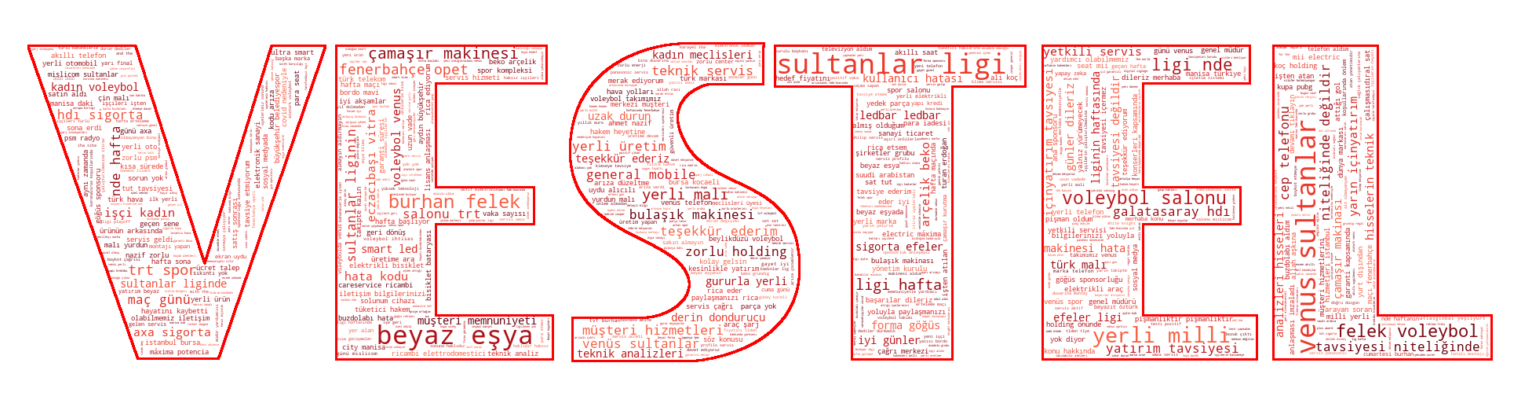

In [178]:

# create a word frequency dictionary
wordfreq = Counter(bigram_words)
# draw a Word Cloud with word frequencies
# open the image and use np.array to transform the file to an array
cand_mask=np.array(Image.open('vestel-kirmizi-logo.png'))

# this line will take all values greater than 3 and make them 255 (white)
# if they are less than 3, they will be whatever value they are in the array
cand_mask=np.where(cand_mask > 3, 255, cand_mask)
# import the desired colormap from matplotlib
cmap = mpl.cm.Reds(np.linspace(0,1,20)) 
# the darker part of the matrix is selected for readability
cmap = mpl.colors.ListedColormap(cmap[-10:,:-1]) 
wordcloud = WordCloud(
                      background_color='white',
                      contour_color='red',
                      contour_width=4,
                      mask=cand_mask, 
                      width=900,
                      height=500,
                      max_words=1000,
                      max_font_size=200,
                      relative_scaling=0.5,
                      colormap=cmap,
                      collocations = False, #tekrar eden kelimeler için "false"
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(27,24))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [19]:
dataset_train.head(10)

,Görüş,Durum,Gorus_token
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz,ses kalite ergonomi rezalet sony olduk iç al a...
1,hizli teslimat tesekkürler,Tarafsız,hizl teslimat tesekkür
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu,ses olay süperge çalış sık yokkablo uzun iş ra...
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz,gelt bigü kullan hemen bozol hiçtavsi etme
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz,kulaklık ses kalite alet öv öv bitiremeyen yor...
5,Giriş seviyesindeki kullanıcılar için kabul ed...,Tarafsız,giriş seviye kullanıç iç kabul edilebilir sonu...
6,kullanisli baya,Olumlu,kullanis ba
7,Dezavantajlar : Pahalı ürün<br />Merhabalar bu...,Tarafsız,dezavantaj paha ürünbr merhap lens başka yer i...
8,ÜRÜN GÜZEL BU PARALARA BAŞKA BULAMAZSINIZ,Tarafsız,ürün güzel para başka bulamaz
9,Tasarım ve kalite iyi olmasına rağmen yazma hı...,Tarafsız,tasar kali iyi olma yazm hız oldukç düşük kalıyor


In [114]:
#BAG OF WORDS APPROACH
# you can see the full list of imports on GitHub!
# Machine Learning imports
import nltk
from nltk.util import ngrams
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
#SAVE MODEL
import pickle

In [115]:
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_features=1500, ngram_range=(1, 3), min_df=5, max_df=0.7,stop_words=stop_words)
bow_x = bow_vectorizer.fit_transform(dataset_train['Gorus_token'])
bow_x = bow_x.toarray()


# example of vectorized text
sample_tweet = dataset_train['Gorus_token'][111]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_vectorizer.transform([sample_tweet])
print(bow_sample)
print('\n')


# transform the entire DataFrame of messages
messages_bow = bow_vectorizer.transform(dataset_train['Gorus_token'])
# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
tfid_x = tfidfconverter.fit_transform(messages_bow).toarray()

#tfidf_transformer = TfidfTransformer().fit(messages_bow)
#tfidf_sample = tfidf_transformer.transform(bow_sample)
#print(tfidf_sample)

# to transform the entire bag-of-words corpus
#messages_tfidf = tfidf_transformer.transform(messages_bow)
print(tfid_x.shape)

olumlu yönleri tesekkur


  (0, 938)	1
  (0, 939)	1
  (0, 1199)	1
  (0, 1347)	1


Shape of Sparse Matrix:  (11438, 1500)
Amount of Non-Zero occurences:  106352
(11438, 1500)


In [116]:
bow=pd.DataFrame(tfid_x, columns = bow_vectorizer.get_feature_names())
bow

,adam,adet,adres,aile,aktif,akıtıyor,akşam,alabilirsiniz,alacak,alacak olanlar,...,ızgara,ışık,şarj,şarjı,şeklinde,şikayet,şimdilik,şirketi,şuan,şık
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125715,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.290036,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
model=MultinomialNB()
X_train, X_test, y_train, y_test = train_test_split(tfid_x,y_durum,test_size=0.2, random_state = 42)


In [68]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 
from sklearn.metrics import f1_score, accuracy_score
y_pred = classifier.predict(X_test)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [118]:
from sklearn.linear_model import LogisticRegression

# training
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train,y_train)

LogisticRegression(max_iter=400)

In [119]:
# testing
y_pred=model.predict(X_test)
from sklearn.metrics import classification_report
cf=classification_report(y_test,y_pred)
print(cf)


              precision    recall  f1-score   support

           0       0.71      0.78      0.74       864
           1       0.49      0.37      0.42       561
           2       0.76      0.82      0.79       863

    accuracy                           0.69      2288
   macro avg       0.66      0.65      0.65      2288
weighted avg       0.68      0.69      0.68      2288



In [120]:
accuracy_score(y_test,y_pred)

0.6931818181818182

In [179]:

# Saving model to disk
pickle.dump(model, open('model.pkl','wb'))


In [180]:
# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))

In [181]:

# run predictions on eksı sozluk data
comments_preds = model.predict(bow_vectorizer.transform(yorumlar_df['Text_token']))
# append predictions to dataframe
df_comments_preds = yorumlar_df.copy()
df_comments_preds['predictions'] = comments_preds
df_comments_preds.shape

(82345, 4)

In [182]:
df_comments_preds['sentiment']=df_comments_preds['predictions'].map({0: 'olumsuz',1:'nötr',2:'olumlu'})

In [183]:
df_comments_preds.head(100)


,Date_time,Text,Text_token,predictions,sentiment
75745,2019-08-08 18:13:43.000000,@fenerkolikorg @buzzspor vestel koclarin degil...,koclarin degilmi gogus formasi,0,olumsuz
75746,2019-08-08 17:56:36.000000,@son_mohikan35 Abi vestel bakarmısın fena ters...,abi bakarmısın fena tersteyim aydır beklemelim...,1,nötr
75747,2019-08-08 17:55:19.000000,@vestel @Trabzonspor #gururlayerli #BugünGünl...,,0,olumsuz
75748,2019-08-08 17:54:55.000000,@son_mohikan35 Sayın mohikan vestel bakar mısı...,sayın mohikan bakar mısın bilanço güzel geldi ...,2,olumlu
75749,2019-08-08 17:53:16.000000,Yalnız #Vestel’in gelişiyle forma cam gibi olm...,yalnız gelişiyle forma cam olmuş,0,olumsuz
...,...,...,...,...,...
82340,3 Ocak 2018,Öyle yani Bazıları reklam falan yaptırıyorlar ...,reklam yaptırıyorlar keşke göründüğü,2,olumlu
82341,3 Ocak 2018,vestel servisi iyi ki.,servisi iyi,1,nötr
82342,14 Ocak 2018,ben Vestel kullandım ve şikayetçi değilim. Ves...,kullandım şikayetçi değilim vesteli giriş mode...,1,nötr
82343,2 Eyl 2018,Ben memnunum kişinin beklentisine göre olmalı,memnunum kişinin beklentisine olmalı,2,olumlu


In [211]:
#df_comments_preds['Date_time'] = pd.to_datetime(df_comments_preds['Date_time'], format="%d %m %y")
# convert the 'Date' column to datetime format
d=df_comments_preds['Date_time']
# Check the format of 'Date' column
#df_comments_preds.info()

import datetime as dt
import locale
locale.setlocale(locale.LC_ALL, '')
string='2 Ağu 2020'
def converttime(x):
    if dt.datetime.strptime(x, '%d %b %Y')== True :
        #https://python-istihza.yazbel.com/standart_moduller/datetime.html
        z=dt.datetime.strptime(x, '%d %b %Y')
        year=z.year  
        return year
        
    elif  dt.datetime.strptime(x, '%d %B %Y') == True :
        z=dt.datetime.strptime(x, '%d %B %Y')
        year=z.year
        return year
    
df_comments_preds['year']=d.apply(lambda x: x.split()[2])
df_comments_preds

IndexError: list index out of range

In [47]:
import zeyrek
analyzer = zeyrek.MorphAnalyzer()
list=analyzer.lemmatize('gözlükçü')

In [184]:
df_comments_preds.sentiment.value_counts(1).head(10)

olumsuz    0.733560
nötr       0.138065
olumlu     0.128375
Name: sentiment, dtype: float64

Text(0, 0.5, 'Number of Comments')

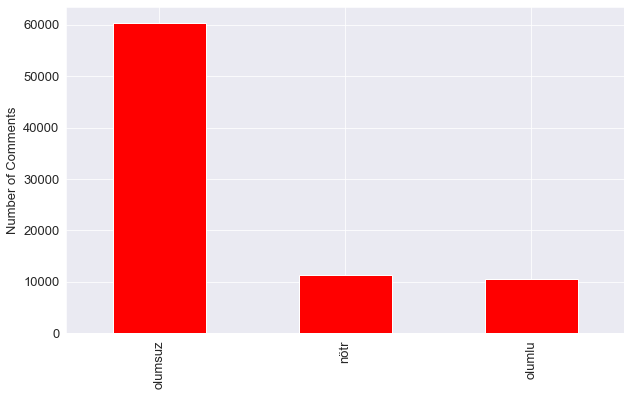

In [185]:
# plot histogram of tweets counts by country of origin
sns.set_style("darkgrid")
x = df_comments_preds.sentiment.value_counts().head(3)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='Red')
plt.ylabel('Number of Comments', fontsize=13)

([<matplotlib.patches.Wedge at 0x1cb45103130>,
 [Text(-0.6419635414497862, 1.0138455560139568, 'olumsuz'),
  Text(0.09127739652774589, -1.0962063842557737, 'nötr'),
  Text(0.9749839193912943, -0.5093195037777274, 'olumlu')],
 [Text(-0.37447873251237523, 0.591409907674808, '68.0%'),
  Text(0.04978767083331593, -0.5979307550486037, '16.7%'),
  Text(0.5318094105770695, -0.27781063842421494, '15.3%')])

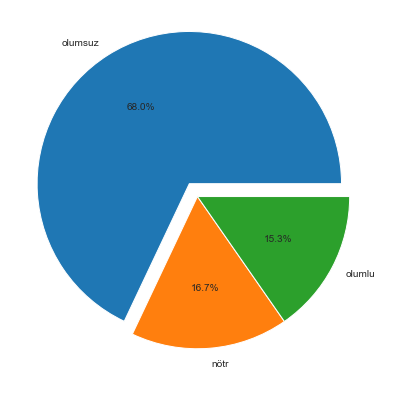

In [79]:
tb_count=  df_comments_preds.sentiment.value_counts()
plt.figure(figsize=(10, 7))
plt.pie(tb_count.values, labels = tb_count.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)



In [186]:
predic_poz = df_comments_preds[ df_comments_preds['predictions'] == 2]
predic_poz=predic_poz['Text_token']
predic_neg = df_comments_preds[ df_comments_preds['predictions'] == 0]
predic_neg = predic_neg['Text_token']
predic_not = df_comments_preds[ df_comments_preds['predictions'] == 1]
predic_not=predic_not['Text_token']

In [188]:
Counter(df_comments_preds[ df_comments_preds['predictions'] == 2]).most_common()

[('Date_time', 1),
 ('Text', 1),
 ('Text_token', 1),
 ('predictions', 1),
 ('sentiment', 1)]

In [47]:
#poz_words=common_words(predic_poz)
Counter(predic_poz).most_common()

[('teşekkür', 78),
 ('koronavirüs ten kişi öldük fabrika vak sayı tırmanıyor', 12),
 ('ingil hostess white knight marka sat al', 11),
 ('cmı wıfı devir çamaşır makine', 10),
 ('telefon model iç kılf mevcut sipariş iç whatsapp mesaj gönderebilirsiniztelefonkilif apple ıphone huawei samsung generalmobi oppo',
  10),
 ('tebrik', 8),
 ('manisa koronavirüs sayı ik kat çıkt say hızl artıyor solhaber', 8),
 ('tse kovid güven üret belge al', 8),
 ('iyi', 7),
 ('koronavirüs önle al dedik iç iş atılan yel kurt vestelboykot çağrısıadalet sağlanan ıscikadi dava peş',
  7),
 ('müşter hizmet iyi işyer seçil', 7),
 ('tse covid güven üret belge al', 7),
 ('harika', 7),
 ('il forma göğüs sponsorluk anlaşma imza sür yıl topla ücret', 7),
 ('amfi progra temmuz', 6),
 ('cmı devir çamaşır makine', 6),
 ('güzel', 6),
 ('celalcifteci izmdc kontrolmatik nuhc idgyo karton ge mgros kolay gels arkadaş',
  6),
 ('program bulaşık makine', 6),
 ('genel gerçek', 5),
 ('good designda ödül al', 5),
 ('gelip kadinmecli

Pozitif kelimeler


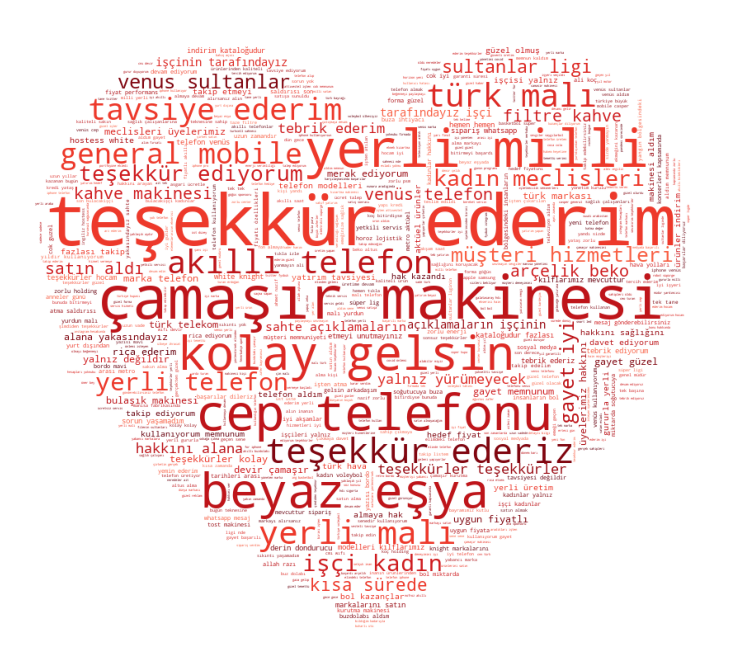

Negatif kelimeler


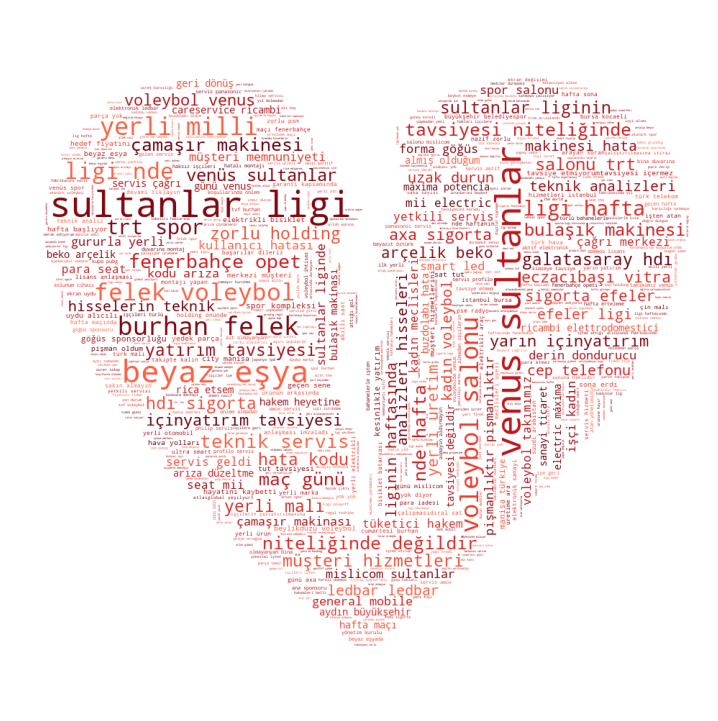

Nötr kelimeler white


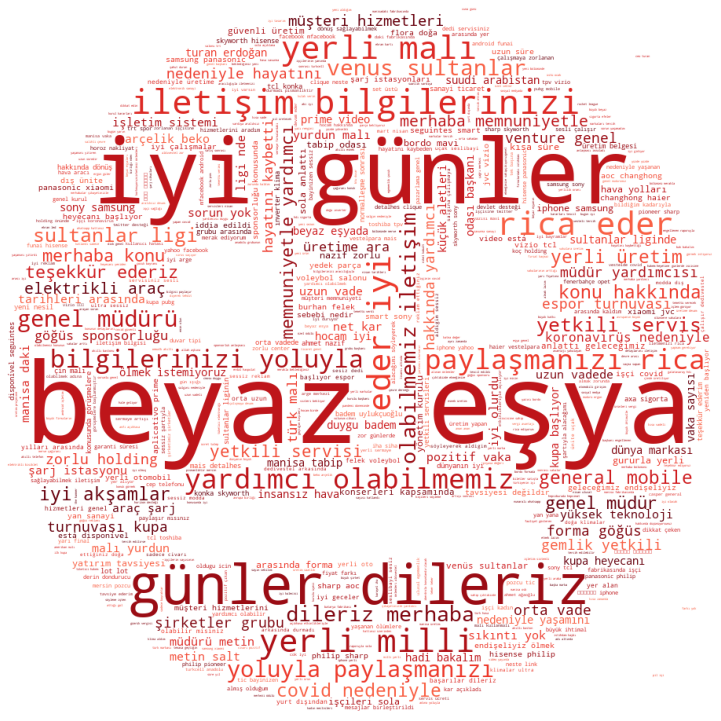

In [189]:
#pos-neg-nötr 


cmap = mpl.cm.Reds(np.linspace(0,1,20)) 
cmap = mpl.colors.ListedColormap(cmap[-10:,:-1]) 
#kaynak:https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis
def wordcloud_draw(data,maskk):
    all_words = []
    for line in list(data):
        words = line.split()
        for word in words:
            all_words.append(word.lower())
    bigrams=ngrams(all_words,2)
    bigram_words = []
    for i, j in bigrams:
         bigram_words.append("{0} {1}".format(i, j))
  
    #maskk=np.where(maskk > 3, 255, maskk)
    wordfreq = Counter(bigram_words)
    wordcloud = WordCloud(
                      background_color='white',
                      mask=maskk,        
                      max_words=1000,
                      max_font_size=200,
                      relative_scaling=0.5,
                      colormap=cmap,
                      stopwords=stop_words,
                      width=2500,
                      height=2000,
                      contour_color='Red',
                      collocations = False #tekrar eden kelimeler için "false"
                     ).generate_from_frequencies(wordfreq)
    plt.figure(figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
  
cand_mask=np.array(Image.open('vestel-kirmizi-logo.png'))
cand_mask1=np.array(Image.open('heart.jpeg'))
cand_mask2=np.array(Image.open('broken.jpg'))
cand_mask3=np.array(Image.open('notr.jpg'))
print("Pozitif kelimeler")
wordcloud_draw(predic_poz,cand_mask1)
print("Negatif kelimeler")
wordcloud_draw(predic_neg,cand_mask2)
print("Nötr kelimeler",'white')
wordcloud_draw(predic_not,cand_mask3)